In [45]:
import sys
import pandas as pd
sys.path.append("..")
import seaborn as sns
import nltk

from humor.metric import fuzzy_match_metric
from humor.bipartite_metric import bipartite_metric

In [46]:
ground_truth = pd.read_csv('/home/ada/humor/data/stand_up_dataset/standup_data.csv')
model = pd.read_csv('/home/ada/humor/data/stand_up_dataset/gemma_answers.csv')
transcript = pd.read_csv('/home/ada/humor/data/stand_up_dataset/standup_transcripts.csv')

In [47]:
#gemma
gemma_metric = bipartite_metric(model, ground_truth)

/home/ada/humor/notebooks/../humor/bipartite_metric.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = scores.groupby(["comedian", "model"])["score", "truth"].max().reset_index()


In [48]:
gemma_metric

,truth,score
0,"""Alright, you guys are all killing it academic...",0.000000
1,"""Because we don't say that when someone gives ...",0.000000
2,"""Click the links below, subscribe, leave a com...",0.000000
3,"""Does the front door not work?"" ""No, it works.",0.000000
4,"""Hi, everyone, same old me.""",0.000000
...,...,...
241,[audience cheers and applauds] He's a surfer. ...,0.206250
242,"[audience laughing] Very sorry, Radio City, di...",0.250000
243,[laughs] It just doesn't work. I remember when...,0.508333
244,[laughter] That kid won't choke on camera. He'...,0.018750


In [49]:
gemma_metric["score"].mean() * 100

2.9098915989159893

In [50]:
#Brute Force
brute_sentences = []
for i in range(len(transcript['comedian'])):
    comedian = transcript['comedian'][i]
    trans = transcript['transcript'][i]
    sentences = nltk.sent_tokenize(trans)
    for sentence in sentences:
        brute_sentences.append({'comedian': comedian, 'sentence': sentence})

In [51]:
brute_model = pd.DataFrame(brute_sentences)

In [52]:
brute = bipartite_metric(brute_model, ground_truth)

/home/ada/humor/notebooks/../humor/bipartite_metric.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = scores.groupby(["comedian", "model"])["score", "truth"].max().reset_index()


In [53]:
brute["score"].mean() * 100

2.050442924314776

In [54]:
#random
random_model = pd.read_csv("/home/ada/humor/data/stand_up_dataset/random_gemma_quotes.csv")
random = bipartite_metric(random_model, ground_truth)
random["score"].mean() * 100

1.8895663956639563

In [55]:
gemma = gemma_metric.assign(model="gemma") 
brute = brute.assign(model="brute") 
random = random.assign(model="random") 

In [56]:
df = pd.concat([gemma, brute, random]).reset_index(drop=True)

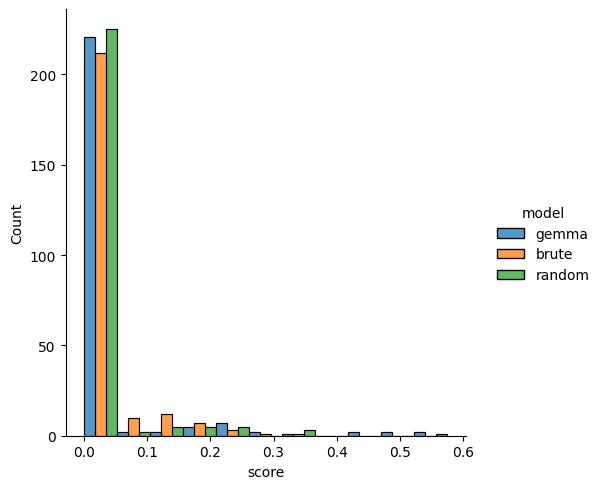

In [57]:
sns.displot(df, x="score", hue="model", kind="hist", shrink=1, multiple="dodge")

In [58]:
phi_model = pd.read_csv("/home/ada/humor/data/stand_up_dataset/phi3_mini_quotes.csv")
phi_metric = bipartite_metric(phi_model, ground_truth)
phi_metric["score"].mean() * 100

/home/ada/humor/notebooks/../humor/bipartite_metric.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = scores.groupby(["comedian", "model"])["score", "truth"].max().reset_index()


2.1959688346883466

In [59]:
phi = phi_metric.assign(model="phi") 

In [60]:
llm = pd.concat([gemma, phi, brute, random]).reset_index(drop=True)

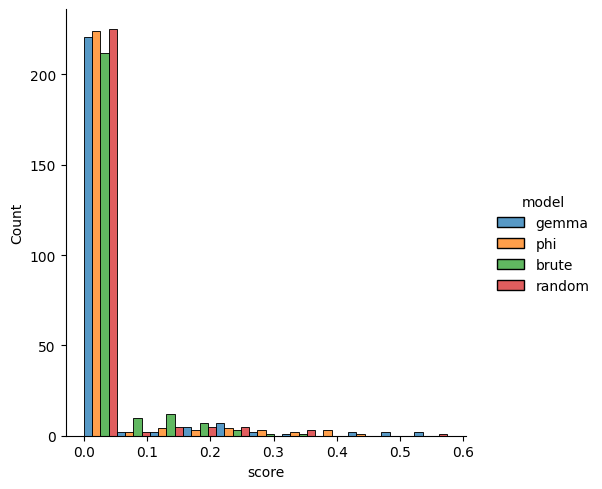

In [61]:
sns.displot(llm, x="score", hue="model", kind="hist", shrink=1, multiple="dodge")

ChatGPT

In [70]:
import pandas as pd
from thefuzz import fuzz

def bipartite_metric(model_answers: pd.DataFrame, ground_truth: pd.DataFrame):    
    scores = model_answers.apply(
        lambda row_model: ground_truth.apply(
            lambda row_truth: 
                fuzz.partial_ratio(row_truth["sentence"], row_model["sentence"]) 
                if row_model["comedian"] == row_truth["comedian"] 
                else None,
        axis=1),
    axis=1) \
        .sub(60) \
        .clip(lower=0) \
        .div(40) \
        .melt(ignore_index=False) \
        .dropna() \
        .reset_index() \
        .join(model_answers["sentence"], on="index") \
        .rename(columns={"sentence": "model"}) \
        .join(ground_truth, on="variable") \
        .rename(columns={"sentence": "truth", "value": "score"})
        
    scores = scores[["comedian", "model", "truth", "score"]]
    
    df = scores.groupby(["comedian", "model"])["score", "truth"].max().reset_index()
    
    truths = scores[~scores['truth'].isin(df['truth'])]
    entries = truths.copy()
    entries['score'] = 0
    df = pd.concat([df, entries[['comedian', 'model', 'truth', 'score']]], ignore_index=True)
    df.sort_values(by=['comedian', 'model'], inplace=True)
    
    return df.groupby("truth")["score"].mean().reset_index()

In [68]:
chat_gpt = pd.read_csv('/home/ada/humor/data/stand_up_dataset/Chat_GPT_results - Sheet1.csv')
chat_gpt_metric = bipartite_metric(chat_gpt, ground_truth)


/home/ada/humor/notebooks/../humor/bipartite_metric.py:26: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = scores.groupby(["comedian", "model"])["score", "truth"].max().reset_index()


In [66]:
chat_gpt

,comedian,sentence
0,Jimmy_Yang,"Asian people, we don’t need Tinder anymore. We..."
1,Jimmy_Yang,"I’ve been dating a lot of tall girls lately, b..."
2,Jimmy_Yang,"She’s like, it makes my ass look better. I’m l..."
3,Jimmy_Yang,Last time– the last time I took a tall girl to...
4,Jimmy_Yang,I’m 5′ 5″. I just go to concerts to smell othe...
5,Jimmy_Yang,"She was having the time of her life, doing wha..."
6,Jimmy_Yang,I was frustrated. I had enough. So I just look...


In [69]:
chat_gpt_metric

,truth,score
0,"Asian people, we don't need Tinder anymore. We...",0.000000
1,I think tall women are beautiful. But some of ...,0.000000
2,I was frustrated. I had enough.,0.000000
3,"Neither of us look good, OK?",0.000000
4,"She's like, it makes my ass look better. I'm l...",0.000000
5,"So I just looked up at her, I was like, hey!",0.078571
